# Movie Classification

In [49]:
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# The Dataset

This project explores movie screenplays, and will try to predict each movie's genre from the text of its screenplay. In particular, there's a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. **All words have been converted to lowercase.**

The cell below will show the `movies` table. **It may take up a few minutes to load.**

In [50]:
movies = Table.read_table('movies.csv')

This `row_for_title` function will provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [51]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie.

## Exploratory Data Analysis: Linear Regression

Before trying to build a classifier, I'll be exploring the dataset. To start, I'll look at the relationship between words in proportions. 

The first association I'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

I'll investigate our data visually before performing any numerical analysis.

The cell below will plot a scatter diagram of space proportions vs outer proportions, creating the `outer_space` table.

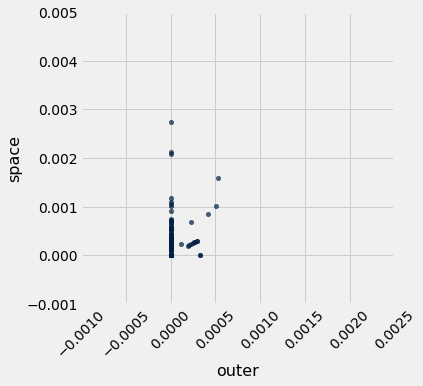

In [53]:
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.001, 0.0025, -0.001, 0.005]);
plots.xticks(rotation=45);

Looking at that chart it is difficult to see if there is an association, so I'll calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset. This value will be assigned to `outer_space_r`.

In [54]:
outer = movies.column("outer")
space = movies.column("space")

def standard_units(number):
    "Convert any array of numbers to standard units."
    return (number - np.mean(number))/np.std(number)

outer_su = standard_units(outer)
space_su = standard_units(space)

outer_space_r = np.mean(outer_su * space_su)
outer_space_r

0.2829527833012742

Now I'll choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 (i.e. words with a positive correlation/mentioned often together) that are not *outer* and *space*, and plot a scatter plot with a line of best fit for them. The two words I'm choosing is "love" and "beauti" (stemmed version of "beautiful")

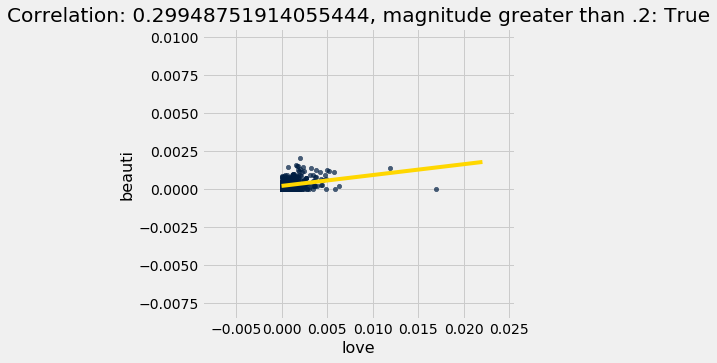

In [55]:
word_x = "love"
word_y = "beauti"

arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x- np.mean(arr_x)) / np.std(arr_x)
y_su = (arr_y- np.mean(arr_y)) / np.std(arr_y)

r = np.mean(x_su * y_su)

slope = (np.std(arr_y) / np.std(arr_x)) * r
intercept = np.mean(arr_y) - (slope * np.mean(arr_x))

movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

## Splitting the dataset
We're going to use our `movies` dataset to:

1. *train* movie genre classifiers.
2. *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

The code below will separate the datasets into two tables.

In [56]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  314 ; Test:  56


I'll now draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset.

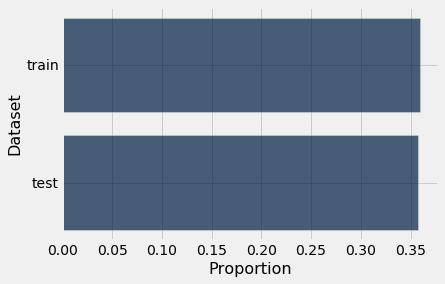

In [57]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the Comedy genre.
    return (table.where("Genre", "comedy").num_rows)/(table.num_rows)

train_pop = comedy_proportion(train_movies)
test_pop = comedy_proportion(test_movies)

bar = Table().with_columns("Proportion", make_array(train_pop, test_pop), "Dataset", make_array("train", "test"))
bar.barh("Dataset")

# 2. K-Nearest Neighbors

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, I'm going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

I'm limiting myself to just 2 features for now, so that I can plot each movie.  The features I will use are the proportions of the words "water" and "feel" in the movie.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the Euclidean distance between them when we plot their features in a scatter diagram. 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies.


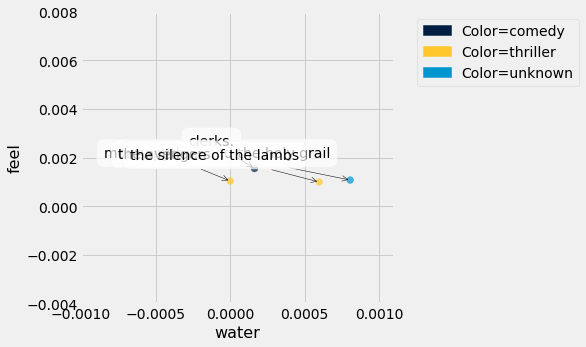

In [58]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=45)
    
training = ["clerks.", "the avengers", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.001, 0.0011, -0.004, 0.008]);

This next function `distance_two_features` computes the Euclidean distance between any two movies, using two features.

In [59]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    title = row_for_title(title0)
    titlea = row_for_title(title1)
    
    title_x_feature = title.item(x_feature)
    title_y_feature = title.item(y_feature)
    
    titlea_x_feature = titlea.item(x_feature)
    titlea_y_feature = titlea.item(y_feature)
    
    return np.sqrt((title_x_feature - titlea_x_feature)**2 + (title_y_feature - titlea_y_feature)**2)

In [60]:
for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance: ', movie_distance)

clerks. distance:  0.0007983810687227951
the silence of the lambs distance:  0.00022256314855568916


This last call shows that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. Interesting! 

I'll now explore which titles and genres in the **training set** are closest to *Monty Python and the Holy Grail.* To do this, I'll first define the function `distance_from_python`. Then, I'll make the table `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table will be **sorted in ascending order by `distance from python`**.

In [61]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features("monty python and the holy grail" ,title , "water" , "feel")

qclose_movies = train_movies.select("Title", "Genre", "water", "feel")
qclose_movies1 = qclose_movies.with_columns("distance from python", qclose_movies.apply(distance_from_python, "Title"))

close_movies = qclose_movies1.sort("distance from python", descending = False).take(np.arange(5))
close_movies


Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


Next, I'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies.

In [62]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    mc = table.group(label).sort("count", descending = True).column(0).item(0)
    return mc

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

We can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie.

# Features

Now, I'm going to extend the classifier to consider more than two features at a time by creating a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length. 
Next, I'll use the function to compute the distance between the first and second movie in the training set *using all of the features*.

In [63]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return (sum(((np.subtract(features_array2, features_array1))**2)))**0.5

worktrain = train_movies.drop(0, 1, 2, 3, 4)
row0 = np.array(worktrain.row(0)) 
row1 = np.array(worktrain.row(1))

distance_first_to_second = distance(row0, row1)
distance_first_to_second

0.03335446890881372

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.

So I'm going to select just 20 *discriminative* features that will lead us to correctly classify as much of the test set as possible.

The plot given will help me visualize the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis.

![alt_text](word_plot.png "Title")

Using the plot above, I'll make an array of 20 common words that I think might let me distinguish between comedy and thriller movies.

In [64]:
my_features = make_array("kill", "dead", "knife", "murder", "death", "scare", "suspici", "blood", "found", "question", "love", 
                         "happili", "yeah", "oh", "uh", "kiss", "great", "nice", "funni", "dumb")

# Select the 20 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)


I chose these particular features based on whether I thought the tone or subject of the features were befitting of either a thriller or a comedy.

Next, I'll classify the first movie from our test set using these features.

In [65]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
new nightmare,thriller


Features:


kill,dead,knife,murder,death,scare,suspici,blood,found,question,love,happili,yeah,oh,uh,kiss,great,nice,funni,dumb
0.000729129,0.000364564,0,0,0,0.000364564,0,0,0,0,0.00109369,0,0.00109369,0.00145826,0,0.000364564,0.00109369,0.000364564,0.000364564,0


As before, I want to look for the movies in the training set that are most like our test movie.  I will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  To make this computationally faster, I'll use function `fast_distances`, to do this.

In [66]:
def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

Using the `fast_distances` function, I'll now compute the distance from "new nightmare" to all the movies in the training set, **using my set of features**.  I'll show this data with table  `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

`genre_and_distances` will be **sorted in ascending order by distance to the first test movie**.

In [67]:
fd = fast_distances(test_my_features.row(0), train_my_features)
genre_and_distances = train_movies.select("Genre").with_columns("Distance", fd).sort("Distance", descending = False)
genre_and_distances

Genre,Distance
comedy,0.00102396
thriller,0.00114544
thriller,0.00142173
thriller,0.00142272
comedy,0.00159385
comedy,0.00166435
comedy,0.0016777
thriller,0.00169741
thriller,0.0017411
thriller,0.00177501


Computing the 11-nearest neighbors classification of "new nightmare," I can decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances I've calculated - "thriller". This happens to be correct! However, if I decided to compute the 7-nearest neighbors classification, then I would've gotten the wrong genre.

## A classifier function

Now I'll write a single function that encapsulates the whole process of classification. It'll return the genre a k-nearest neighbor classifier picks for the given row of features.

In [68]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    
    #test_row_features_array: test_row
    #train = train_rows
    
    train_with_distances = train_rows.with_columns("Distances", distances, "Genre", train_labels)
    nearest_neighbors = train_with_distances.sort("Distances", descending = False).take(np.arange(k))
    most_common_label = nearest_neighbors.group("Genre").sort("count", descending = True).column(0).item(0)
    return most_common_label

When I evaluate my classifier, it'll be helpful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`. So now I'll create a classification function that takes my 20 features and classifies that row using the 13-nearest neighbors algorithm with `train_20` as its training set.

In [69]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column("Genre"), 13)

## Evaluating your classifier


Now that it's easy to use the classifier, let's see how accurate it is on the whole test set, then figure out where it makes mistakes.

In [70]:
test_guesses = test_my_features.apply(classify_feature_row)
proportion_correct = np.count_nonzero(test_movies.column("Genre")==test_guesses)/(len(test_guesses))
proportion_correct

0.7678571428571429

In [71]:
test_movie_correctness = test_movies.select(0, "Genre").with_columns("Was correct", test_movies.column("Genre")==test_guesses)
test_movie_correctness.sort('Was correct', descending = False).show(20)

Title,Genre,Was correct
the grifters,thriller,False
smoke,comedy,False
mystery of the wax museum,thriller,False
fast times at ridgemont high,comedy,False
the fifth element,thriller,False
the butterfly effect,thriller,False
misery,thriller,False
smokey and the bandit,comedy,False
tron,thriller,False
happy birthday wanda june,comedy,False


I did not go through all of the movies, but from the couple I looked into, the ratings of the movies (PG-13, R, NR) seems to play a role in misclassifications. One example is The Fifth Element; despite being a thriller, since it is PG-13 I believe the language is slightly varied from other thrillers and thus is misclassified. Another example is Fast Times at Ridgemont High, which is rated R and thus could have led to a misclassification.

Now, it's time to build a better classifier.

In [72]:
new_features = make_array("kill", "dead", "knife", "murder", "death", "scare", "suspici", "blood", "cop", "question", "love", 
                          "happili", "yeah", "laugh", "marri", "kiss", "great", "nice", "funni", "dumb")

train_new = train_movies.select(new_features)
test_new = test_movies.select(new_features)

def another_classifier(row):
    return classify(row, train_new, train_movies.column("Genre"), 30)
ntest_guesses = test_new.apply(another_classifier)
nproportion_correct = np.count_nonzero(test_movies.column("Genre")==ntest_guesses)/(len(ntest_guesses))
nproportion_correct

0.8035714285714286

In [73]:
ntest_movie_correctness = test_movies.select(0, "Genre").with_columns("Was correct", test_movies.column("Genre")==ntest_guesses)
ntest_movie_correctness.sort('Was correct', descending = False).show(20)

Title,Genre,Was correct
smoke,comedy,False
mystery of the wax museum,thriller,False
the fifth element,thriller,False
his girl friday,comedy,False
misery,thriller,False
monty python and the holy grail,comedy,False
o brother where art thou?,comedy,False
happy birthday wanda june,comedy,False
cruel intentions,thriller,False
the thin man,comedy,False


I initially changed my features, expecting it to fare better than my previous features list. To my surprise, it did not, even though the previous list included features with extremely common words like "oh" and "uh". I played around with the k value, and found that it did better for k values larger than 13 (80% vs. 76%) until the k value of 30. I'm inferring that after 30 "nearest neighbors" there is too much data that we are considering within the 76 data points to be increasingly accurate. I'm still getting a few wrong, despite the distinct tones of the words I used; however, I do not see a pattern amongst the incorrect answers. I believe to decrease the incorrect classifications, I could focus on finding a way to calculate distance in a more precise manner than Euclidean distance.